## Imports

> **Note:** In this notebook, we are extendng the training data to try and increase the model accuracy on unseen data when published.

Datasets:
* [Emotion Dataset for NLP](https://www.kaggle.com/code/kushagrakesarwani/sentiment-analysis/input)
* [Emotions](https://www.kaggle.com/datasets/nelgiriyewithana/emotions) from Kaggle is explored as an option to extend the dataset.
* 

In [1]:
import gradio as gr
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from timeit import default_timer as timer
from helper_functions import plot_pie_chart, preprocess_text, plot_training_history, preprocess_single_sentence
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR= 'kaggle/input/emotion-dataset-for-nlp/'
TRAIN_FILE = 'train.txt'
VAL_FILE = 'val.txt'
TEST_FILE = 'test.txt'
EMOTION_FILE= 'kaggle/input/Emotion_classify_Data.csv'
EMOTIONS_DATASET= 'kaggle/input/text.csv'

In [3]:
train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'], dtype=str)
df= pd.read_csv(EMOTIONS_DATASET, delimiter=',', header=None, names=['text', 'label'], dtype=str)

In [4]:
df.reset_index(drop=True, inplace=True)
df.drop(index=0, inplace=True)
df.head()

,text,label
1,i just feel really helpless and heavy hearted,4
2,ive enjoyed being able to slouch about relax a...,0
3,i gave up my internship with the dmrg and am f...,4
4,i dont know i feel so lost,0
5,i am a kindergarten teacher and i am thoroughl...,4


In [5]:
emotions_dataset_label = {'0': 'sadness', '1': 'joy', '2': 'love', '3': 'anger', '4': 'fear', '5': 'surprise'}
df['label'] = df['label'].replace(emotions_dataset_label)
new_df= pd.concat([df, train_df])
del(df, train_df)
train_df = new_df.sample(frac=1)
train_df.reset_index(drop=True, inplace=True)
del(new_df)
train_df.info()
train_df['text'].drop_duplicates(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432809 entries, 0 to 432808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    432809 non-null  object
 1   label   432809 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432809 entries, 0 to 432808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    432809 non-null  object
 1   label   432809 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


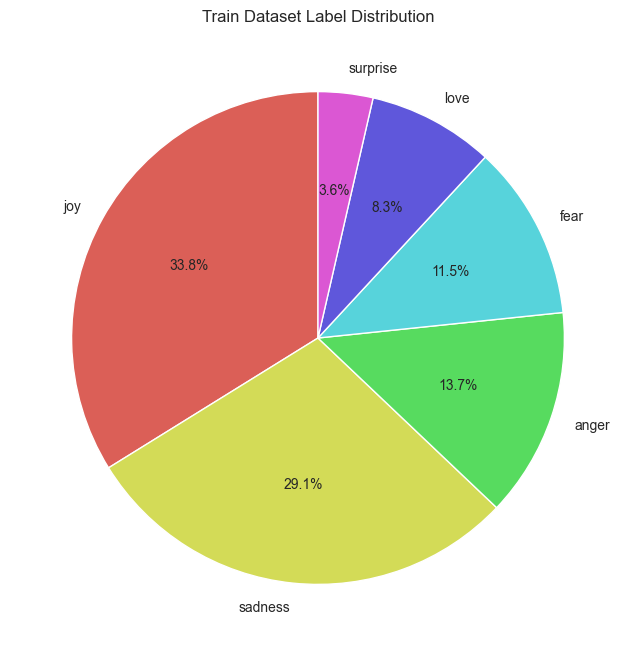

In [7]:
plot_pie_chart(train_df, 'Train Dataset')

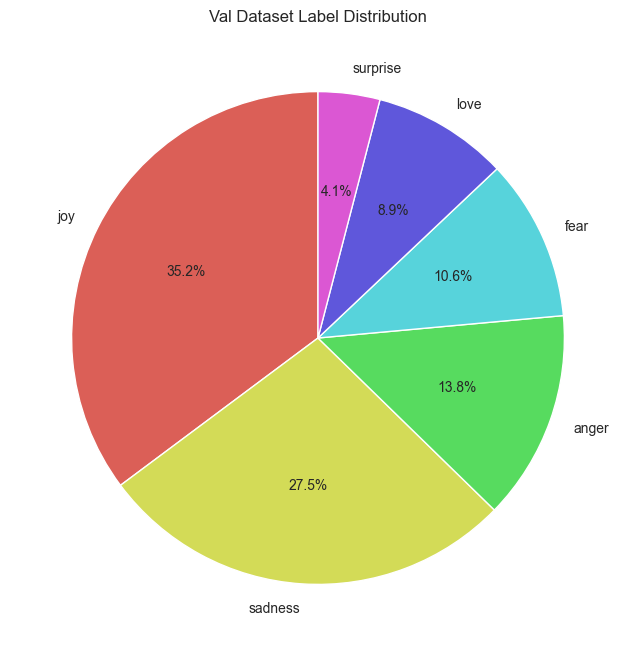

In [8]:
plot_pie_chart(val_df, 'Val Dataset')

## Preprocessing

In [9]:
train_df['label']= train_df['label'].str.replace('love', 'joy')
val_df['label']= val_df['label'].str.replace('love', 'joy')

In [12]:
train_df['label'].value_counts()

label
joy         182287
sadness     125853
anger        59476
fear         49649
surprise     15544
Name: count, dtype: int64

In [13]:
val_df['label'].value_counts()

label
joy         882
sadness     550
anger       275
fear        212
surprise     81
Name: count, dtype: int64

In [14]:
train_df= preprocess_text(train_df)
val_df= preprocess_text(test_df)

## Visualisation

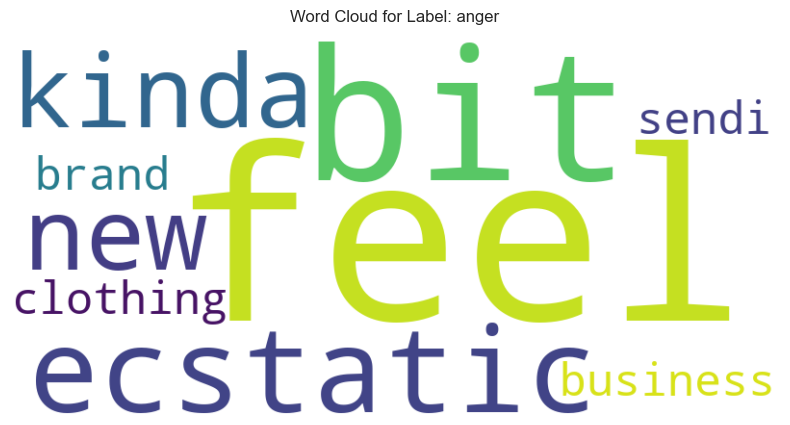

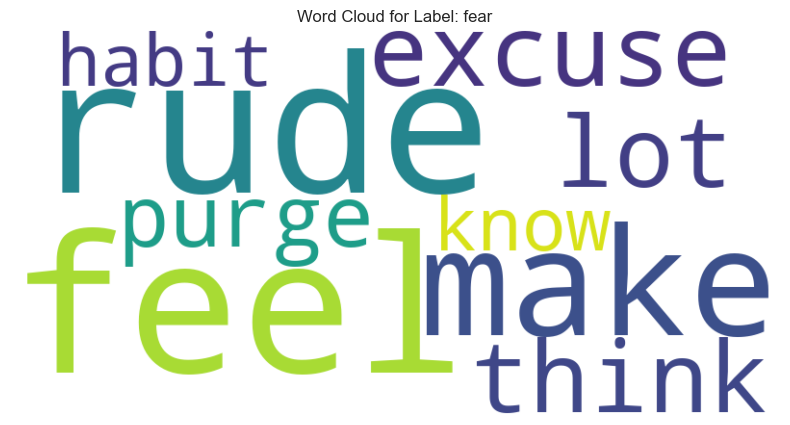

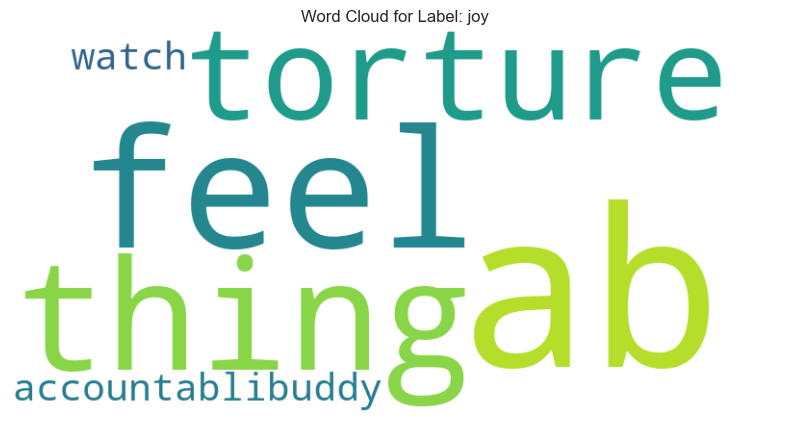

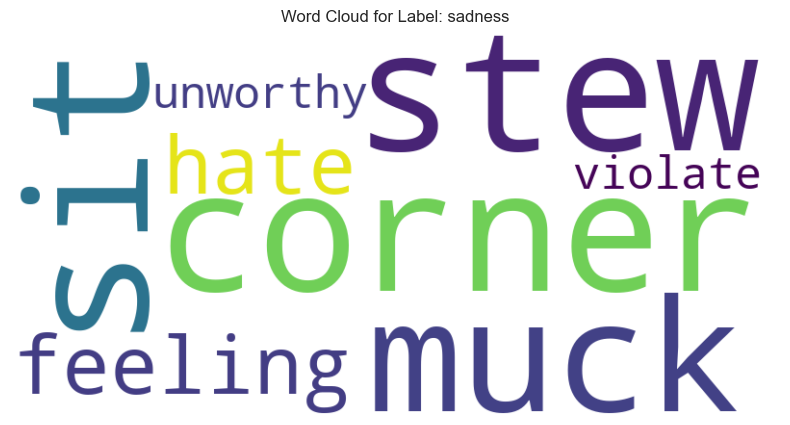

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()] 

encoder= LabelEncoder()
encoder.fit(labels)

# Generate and plot word cloud for each label
for class_label, text in zip(labels, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [20]:
VOCAB_SIZE= 60000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'])

In [21]:
EMBEDDING_UNITS= 64
UNITS= 128
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])

model_v2= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.LSTM(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])


In [22]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
model_v2.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [23]:
GRU_MODEL= 'models/best_gru_model.keras'
LSTM_MODEL= 'models/best_lstm_model.keras'

gru_checkpoint_callback = ModelCheckpoint(filepath=GRU_MODEL,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)

lstm_checkpoint_callback = ModelCheckpoint(filepath=LSTM_MODEL,
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           mode='max',
                                           verbose=1)

In [24]:
BATCH_SIZE= 128
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values, train_df['label_num'].values)).batch(BATCH_SIZE)
val_set= tf.data.Dataset.from_tensor_slices((val_df['processed_text'].values, val_df['label_num'].values)).batch(BATCH_SIZE)

In [25]:
EPOCHS= 10
history_model_v1= model_v1.fit(train_set,
                               validation_data= val_set,
                               epochs= EPOCHS,
                               callbacks= [gru_checkpoint_callback])

Epoch 1/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8906 - loss: 0.2707
Epoch 1: val_accuracy improved from -inf to 0.96789, saving model to models/best_gru_model.keras
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 104s 32ms/step - accuracy: 0.8906 - loss: 0.2706 - val_accuracy: 0.9679 - val_loss: 0.0634
Epoch 2/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9690 - loss: 0.0663
Epoch 2: val_accuracy improved from 0.96789 to 0.97014, saving model to models/best_gru_model.keras
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 101s 31ms/step - accuracy: 0.9690 - loss: 0.0663 - val_accuracy: 0.9701 - val_loss: 0.0533
Epoch 3/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9718 - loss: 0.0589
Epoch 3: val_accuracy improved from 0.97014 to 0.97296, saving model to models/best_gru_model.keras
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 101s 31ms/step - accuracy: 0.9718 - loss: 0.0589 - val_accuracy: 0.9730 - val_loss: 0.0489
Epoch 4/10
3259/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9

In [26]:
history_model_v2= model_v2.fit(train_set,
                               validation_data= val_set, 
                               epochs= EPOCHS,
                               callbacks= [lstm_checkpoint_callback])

Epoch 1/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8779 - loss: 0.2971
Epoch 1: val_accuracy improved from -inf to 0.96901, saving model to models/best_lstm_model.keras
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 109s 33ms/step - accuracy: 0.8779 - loss: 0.2970 - val_accuracy: 0.9690 - val_loss: 0.0629
Epoch 2/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9689 - loss: 0.0671
Epoch 2: val_accuracy did not improve from 0.96901
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 110s 34ms/step - accuracy: 0.9689 - loss: 0.0671 - val_accuracy: 0.9673 - val_loss: 0.0551
Epoch 3/10
3259/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9715 - loss: 0.0585
Epoch 3: val_accuracy improved from 0.96901 to 0.97239, saving model to models/best_lstm_model.keras
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.9715 - loss: 0.0585 - val_accuracy: 0.9724 - val_loss: 0.0464
Epoch 4/10
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9734 - loss: 0.0528
Epoch 4: val_accuracy improv

## Plotting the losses and accuracy

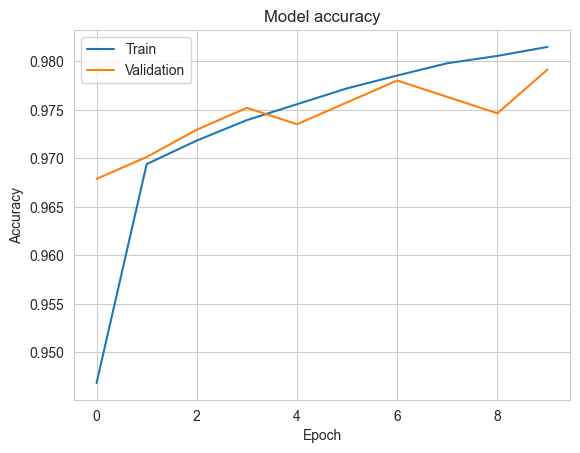

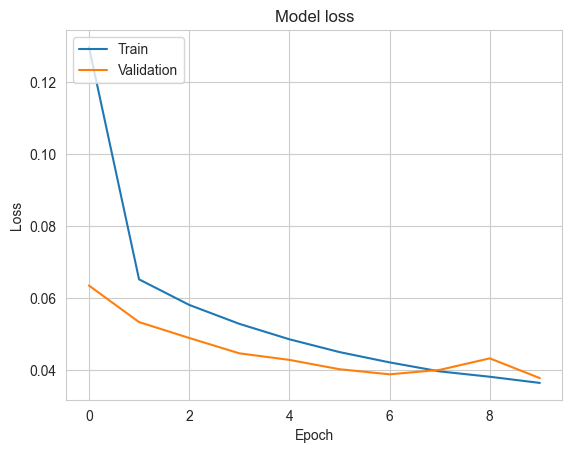

In [27]:
plot_training_history(history_model_v1)

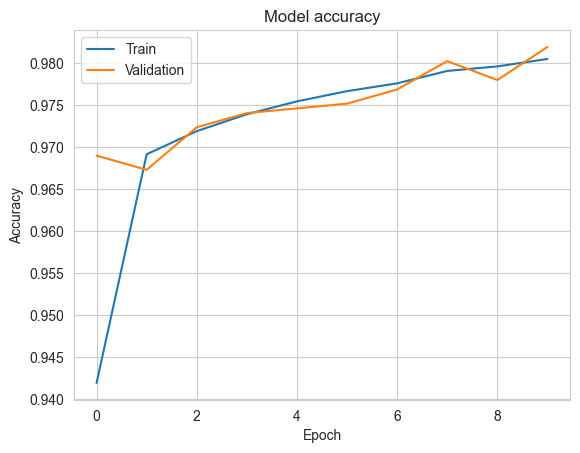

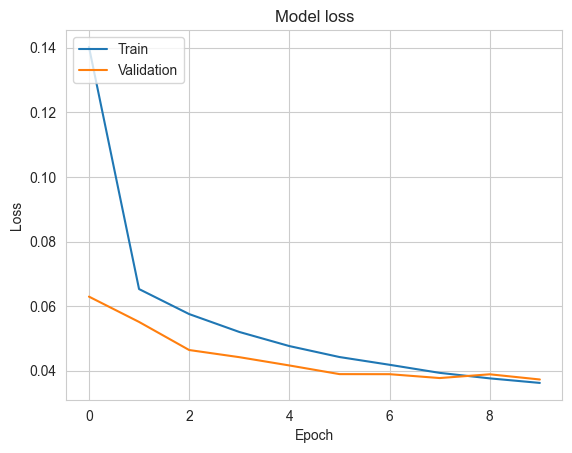

In [28]:
plot_training_history(history_model_v2)

## Evaluate the model

In [29]:
def evaluate_true_vs_predicted(true_labels, predicted_labels):
    """
    Evaluates the true versus predicted labels using accuracy and confusion matrix.

    Parameters:
    true_labels (numpy array): Array containing true labels.
    predicted_labels (numpy array): Array containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the predictions.
    confusion_mat (numpy array): Confusion matrix.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, confusion_mat

In [30]:
del(model_v1, model_v2)

In [31]:
model_v1 = tf.keras.models.load_model(GRU_MODEL)

In [32]:
test_df= preprocess_text(test_df)

In [33]:
test_df.reset_index(drop=True, inplace= True)
true_labels= test_df['label_num']
pred_labels= []
for i in range(len(true_labels)):
    sample_text= test_df['processed_text'][i]
    sample_text= tf.expand_dims(sample_text, 0)
    prob= model_v1.predict(sample_text)
    prob= prob[0]
    pred_label= np.argmax(prob)
    pred_labels.append(pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

In [34]:
accuracy, confusion_mat = evaluate_true_vs_predicted(true_labels, predicted_labels=pred_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9792


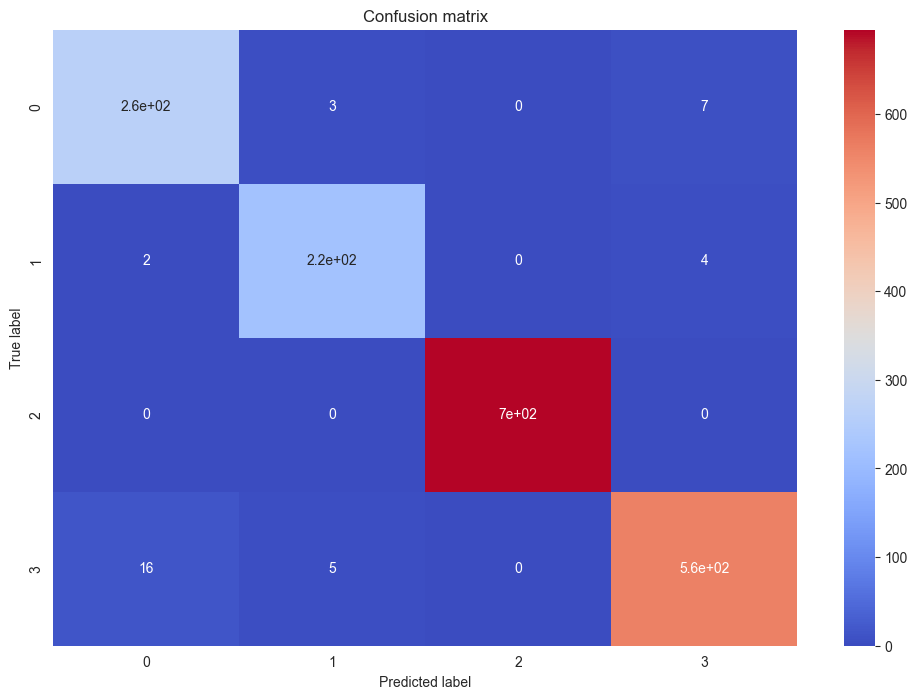

In [35]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_mat, annot=True, cmap='coolwarm')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
comparison_df = pd.DataFrame({
    'True_Label': encoder.inverse_transform(true_labels),
    'Predicted_Label': encoder.inverse_transform(pred_labels),
    'Text': test_df['processed_text'] 
})

wrong_predictions_df = comparison_df[comparison_df['True_Label'] != comparison_df['Predicted_Label']]

print("Wrongly Predicted Labels vs. True Labels:")
wrong_predictions_df

Wrongly Predicted Labels vs. True Labels:


,True_Label,Predicted_Label,Text
10,fear,anger,don t feel particularly agitated
160,sadness,anger,feel like loser say lose not know exactly hate oh
174,anger,sadness,not like quinn feel like end hurt barney hate ...
210,fear,sadness,love dance feel inhibit body unsure capable hy...
225,sadness,anger,hope help charity work feel stress thing
273,fear,anger,know mean feel agitated
279,sadness,anger,nolonger tell anybody feel m think cause hate
285,sadness,anger,feel stressed love feeling calm spirit heavenl...
297,sadness,anger,feel stressed
369,anger,sadness,sit home revising today feeling stressed


In [37]:
wrong_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 10 to 1767
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   True_Label       37 non-null     object
 1   Predicted_Label  37 non-null     object
 2   Text             37 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [38]:
with open('kaggle/examples.txt', 'r') as f:
    example_list = [example.strip() for example in f.readlines()]

encoder= LabelEncoder()
encoder.fit(labels) 

nlp = spacy.load("en_core_web_sm")

def predict(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    start_time= timer()
    text= preprocess_single_sentence(text)
    text= tf.expand_dims(text, 0)

    probability = model_v1.predict(text)
    pred_label_with_prob= {labels[i]: float(probability[0][i]) for i in range(len(labels))} 
    pred_time = round(timer() - start_time, 5)
    return pred_label_with_prob, pred_time

### Gradio App
input= gr.Textbox(lines=5, label="Enter text", placeholder="i like to have the same breathless feeling as a reader eager to see what will happen next")
outputs=[
        gr.Label(num_top_classes=len(labels), label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ]
title= ' Sentiment Analysis 🤣😱😡😢 '
description= 'The sentiment analysis model is a deep learning-based natural language processing (NLP) model designed to analyze and classify the sentiment expressed in text data. It is trained to understand the emotional tone of text and categorize it into predefined sentiment categories such as <b>anger, fear, saddness and joy.<b>'
demo= gr.Interface(fn=predict, 
                   inputs=input, 
                   outputs=outputs, 
                   title=title, 
                   description=description,
                   examples= example_list
                  )
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
